In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_paper2019/mplstyles


# ER/NR Band Calculation

In a previous notebook `QEr_2D_joint.ipynb` we calculated the correct two-dimensional probability distribution for energy recoils of arbitrary average ionization yield, given the resolutions ($\sigma_H$,$\sigma_I$, and $\sigma_N$) as functions of the true recoil energy. The variance on the number of e/h pairs created, $\sigma_N$ included the effective Fano factor, $F$. 

This was all done starting from the fundamental variables $\delta H$, $\delta I$, and N (see `QEr_2D_joint.ipynb` for all variable definitions). The final result was the probability distribution in the Q,$\tilde{E}_r$ plane of measured yield and recoil energy, given a true recoil distribution $P(E_r)$. $P(E_r)$ was taken to be:

\begin{equation}
P(E_r) = \frac{1}{\alpha}e^{-\alpha E_r},
\end{equation}

where $\alpha$ is the decay constant and we take to be equal to about 1/100 keV$^{-1}$ for nuclear recoils.

In this note we will use this model to construct the variance of constant-$\tilde{E}_r$ slices of this distribution. The motivation for this calculation is that these variances are often the ones measured in experiments like Edelweiss [REF] and SuperCDMS. 

## Ionization Yield Distributions at Fixed $\tilde{E}_r$

First, we want to construct bands for electron recoils with the parameters $F^{\prime}$=0 (Fano factor) and $\alpha^{\prime}$ = 1/100000 keV$^{-1}$ (essentially flat true recoil distribution).

**NOTE: The value of $F^{\prime}$ is choosen as such because the measured resolutions are done with electron recoils and implicitly include the true Fano factor. Although this Fano factor (typically in germanium of order 0.13 with large variability in the measurements [REF]) is included note that it is not included correctly because it is not separated from the variance of $\delta I$. Nevertheless, since the Fano contribution for electron recoils is small compared to the ionization resolutions in most published work, it is safely parameterized inside the $\delta I$ resolution for electron recoils.**

Next we will construct a nuclear recoil band with the parameters $F$=15 (this appears to be a plausible lower limit for measurements above 10 keV, see [REF] Dougherty, and the notebook constructing the Fano factor from that) and $\alpha$=1/100 keV$^{-1}$. 

We are constructing the distribution that results from the following:

\begin{equation}
P(Q,\tilde{E}_r=E) = \int_0^{\infty} dE_r P(Q,\tilde{E}_r=E|E_r)P(E_r)
\end{equation}

the following two cells set all the parameters and get the correct resolutions. I am using detector GGA1 here to compare with because in Fig. 5 of the Edelweiss paper [REF] those bands are actually plotted and we have digitized versions of the 90% (1.645$\sigma$) containment bands. 

In [2]:
#constants
V=4.0 #volts
eps = 3.0/1000 #keV per pair, I usually use 3.3 for the numerator, but Edw. uses 3.
FWHM_to_SIG = 1 / (2*np.sqrt(2*np.log(2)))

#yield models
a=0.16
b=0.18
Qbar = lambda Er: a*Er**b
Qer = lambda Er: 1

In [3]:
#getting the resolutions
import EdwRes as er

#these happen to be the parameters for GGA1 detector (Edelweiss)
aH=0.02
fh2 = er.get_heatRes_func(1.3, 3.5,aH*FWHM_to_SIG)
sigH = lambda x:fh2(x)

fi2 = er.get_ionRes_func(1.3, 1.3, 2.8)
sigI = lambda x:fi2(x)

#new resolution functions 
Ehee = lambda Er: ((1+(V/(1000*eps))*Qbar(Er))*Er)/(1+(V/(1000*eps)))
EIee = lambda Er: Qbar(Er)*Er


sigH_NR = lambda Er: sigH(Ehee(Er))

sigI_NR = lambda Er: sigI(EIee(Er))

#check sigI @ 122keV
print('FWHM @ 122 keV: {}'.format(2.355*sigI(122)))

FWHM @ 122 keV: 2.8002139755495987


In the next two cells, I set up the proability distributions for the afromentioned parameters with the functions developed as a result of the `QEr_2D.ipynb` notebook. 

As a test energy I choose 10 keV because the distributions begin to look wide and clearly non-Gaussian there. At that energy we take a slice of the $P(Q,\tilde{E}_r)$ distribution, and calculate the integral so that we can properly normalize it. This is the ionization yield distribution that would be observed at a single measured recoil energy, $\tilde{E}_r$. 

In [4]:
import prob_dist as pd

#set up ER distribution
Fp = 0.0001
alphap=1/100000
Per = pd.QEr_v2_2D_fast(sigH,sigI,V,eps,Fp,Qer)
er_band = pd.expband_2D(Per,alphap,3)

#set up NR distribution
F = 15
alpha=1/100.0
Pnr = pd.QEr_v2_2D_fast(sigH_NR,sigI_NR,V,eps,F,Qbar)
nr_band = pd.expband_2D(Pnr,alpha,1.5)

In [5]:
#test the dists at a certain energy
Etest=10

from scipy import integrate
ernorm = integrate.quad(er_band,0,4,args=(Etest,))[0]
nrnorm = integrate.quad(nr_band,0,4,args=(Etest,))[0]
print(ernorm)
print(nrnorm)

X=np.arange(0,1.5,0.01)
Qdist_er = lambda Q: (1/ernorm)*er_band(Q,Etest)
Qdist_nr = lambda Q: (1/nrnorm)*nr_band(Q,Etest)
Qerv = np.vectorize(Qdist_er)
Qnrv = np.vectorize(Qdist_nr)
Yer = Qerv(X)
Ynr = Qnrv(X)

100038.55775424647
88.38426954941066


The next two cells show the ER and NR distributions for the above parameters on a logarithmic and linear vertical scale. It can be seen on the logarithmic plots that the distributions are not Gaussian. 

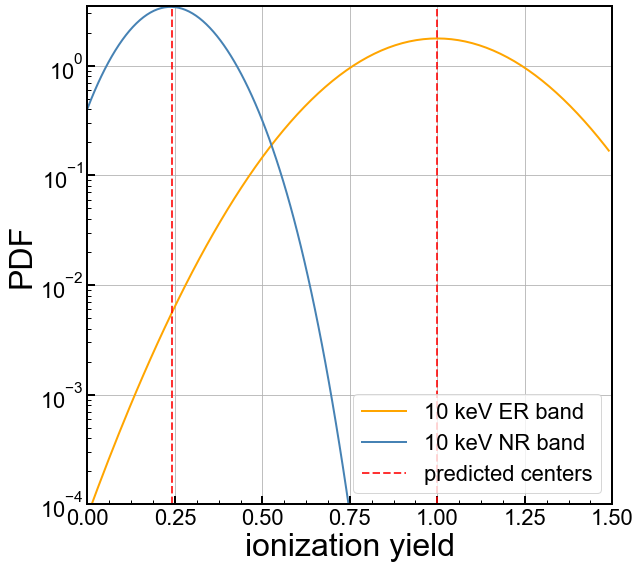

In [6]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



ax1.plot(X,Yer,color='orange',linestyle='-',label='{} keV ER band'.format(Etest))
ax1.plot(X,Ynr,color='steelblue',linestyle='-',label='{} keV NR band'.format(Etest))

ax1.axvline(Qbar(Etest), color='r', linestyle='--', lw=2, alpha=0.8,label='predicted centers')
ax1.axvline(1, color='r', linestyle='--', lw=2, alpha=0.8)

ymin = 1e-4
max1 = np.max(Yer)
max2 = np.max(Ynr)
ymax = 1.01*np.max(np.asarray([max1,max2]))

ax1.set_yscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(0, 1.5) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

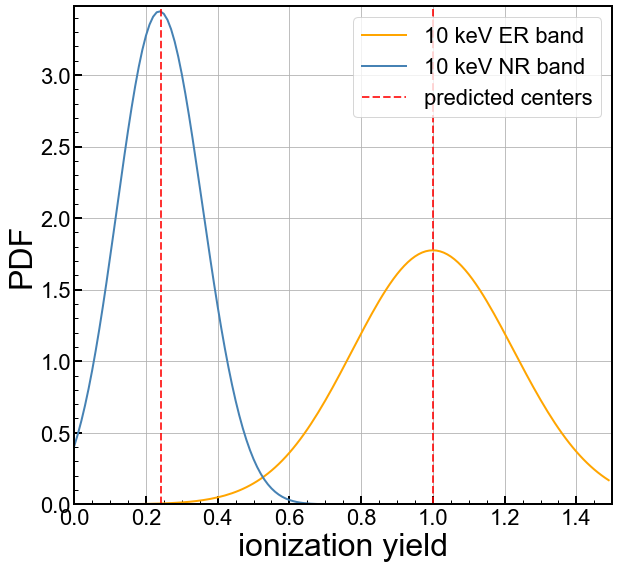

In [7]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



ax1.plot(X,Yer,color='orange',linestyle='-',label='{} keV ER band'.format(Etest))
ax1.plot(X,Ynr,color='steelblue',linestyle='-',label='{} keV NR band'.format(Etest))

ax1.axvline(Qbar(Etest), color='r', linestyle='--', lw=2, alpha=0.8,label='predicted centers')
ax1.axvline(1, color='r', linestyle='--', lw=2, alpha=0.8)

ymin = 1e-4
max1 = np.max(Yer)
max2 = np.max(Ynr)
ymax = 1.01*np.max(np.asarray([max1,max2]))

ax1.set_yscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0, 1.5) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

## The 68.27% Symmetric Containment Region

Since these distributions are not quite Gaussian for all combinations of parameters, we must approximate the widths, $\sigma_Q(\tilde{E}_r)$. We define these to be the symmetric regions about the expected yield centers (note, it may be true that in some cases the distribution can be skewed so that neither the mean nor the mode are at the expected yield centers) that contain 68.27% of the distribution. 

For this we can use the optimization libraries in `scipy.optimize`. We define a numerical function that will be zero when the size of the aformentioned region is supplied as an argument. 

In [8]:
import scipy.optimize as so

Qint_er = lambda a: integrate.quad(Qerv,Qer(Etest)-a,Qer(Etest)+a,limit=100)[0]
Qint_nr = lambda a: integrate.quad(Qnrv,Qbar(Etest)-a,Qbar(Etest)+a,limit=100)[0]

siger_zero = lambda a: Qint_er(a) - 0.6827 #one sigma
signr_zero = lambda a: Qint_nr(a) - 0.6827 #one sigma

siger_90 = lambda a: Qint_er(a) - 0.9 #90%
signr_90 = lambda a: Qint_nr(a) - 0.9 #90%

sigQer = so.brentq(siger_zero,0,1,rtol=0.001,maxiter=100)
print(sigQer)
sigQnr = so.brentq(signr_zero,0,1,rtol=0.001,maxiter=100)
print(sigQnr)

sigQer90 = so.brentq(siger_90,0,1,rtol=0.001,maxiter=100)
print('1.645xone sigma: {}; 90\%:{}'.format(1.645*sigQer,sigQer90))
sigQnr90 = so.brentq(signr_90,0,1,rtol=0.001,maxiter=100)
print('1.645xone sigma: {}; 90\%:{}'.format(1.645*sigQnr,sigQnr90))

0.22478180172240245
0.11474735445072594
1.645xone sigma: 0.36976606383335203; 90\%:0.3698908536745943
1.645xone sigma: 0.18875939807144418; 90\%:0.1840166980484885


In [9]:
import time
start = time.time()
#root = pd.sigrootEdw(10,10,V,eps,(1/100),Qbar)
root = pd.sigrootEdw(Fp,7,V,eps,alphap,Qer)
end = time.time()
print('sigma: {}'.format(root))
print('{} s'.format(end - start))

sigma: 0.3220219209327321
9.04426646232605 s


In [10]:
import fano_calc as fc

(nrsigma,nrE) = fc.calcQWidth(10,F,V,eps,alpha,Qbar,aH)
(ersigma,erE) = fc.calcQWidth(10,Fp,V,eps,alphap,Qer,aH)

In the Edelweiss paper [REF], a Gaussian approximation was used wherein the width in ionization yield could be written as:

\begin{equation}
\sigma_Q(\tilde{E}_r) \simeq \frac{1}{\tilde{E}_r} \sqrt{\left(1+\frac{V}{\epsilon}\bar{Q}\right)^2\sigma_I^2 + \left(1+\frac{V}{\epsilon}\right)^2\bar{Q}^2\sigma_H^2}.
\end{equation}

It is therefore useful to compare this function to the values obtained from the more fundamental derivation that we are seeking. 

In [11]:
#make functions for analytical bands
sigQer = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps))*Qer(Etr))**2*sigI(Etr)**2 + (1+(V/(1000*eps)))**2*Qer(Etr)**2 \
                                     *sigH(Etr)**2)
 
sigQnr = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps))*Qbar(Etr))**2*sigI_NR(Etr)**2 + (1+(V/(1000*eps)))**2*Qbar(Etr)**2 \
                                     *sigH_NR(Etr)**2)

print(sigQer(10))
print(sigQnr(10))
sigQerv = np.vectorize(sigQer)
sigQnrv = np.vectorize(sigQnr)

0.2246462352359262
0.10795032751310846


## Comparing Modeled and Edelweiss Published Bands

Since we can now calculate the 68.27% containments at a given recoil energy, we can find what they are for all recoil energy and compare to the bands published in the Edelweiss paper [REF]. We compare for detector GGA1, because that is the detector that the Edw. paper shows the bands from. 

In [12]:
import pandas as pd
band_data = pd.read_csv("data/edelweiss_bands_GGA1.csv")
print (band_data.head(10))

       x   Curve1   curve2   curve3   curve4
0  1.667 -6.44581 -0.08957  1.49300 -0.64478
1  1.802 -6.06069 -0.08789  1.44296 -0.62392
2  1.804 -6.05415 -0.08786  1.46798 -0.62356
3  1.938 -5.68168 -0.08613  1.41795 -0.60321
4  2.075 -5.31531 -0.08430  1.39293 -0.58303
5  2.212 -4.96139 -0.08240  1.36791 -0.56335
6  2.883 -3.39678 -0.07177  1.11174 -0.47381
7  3.158 -2.83384 -0.06656  1.10052 -0.44031
8  3.295 -2.57110 -0.06372  1.06171 -0.42438
9  4.518 -0.66571 -0.01776  0.75550 -0.30031


In [13]:
# path 0: 68.75 keV inelastic scattering
# path 1: average NR line
# path 2: 13.26 keV inelastic
# path 3: ionization threshold
# path 4: lower nuclear recoil band
# path 5: upper nuclear recoil band
# path 6: upper and lower electron recoil band
import pandas as pd
band_data_svg = pd.read_csv("data/edelweiss_band_GGA1_allCurveData.txt", skiprows=1, header=None, delim_whitespace=True)
print (band_data_svg.head(5))
list(band_data_svg.columns.values)

        0         1        2         3        4         5        6        7   \
0  69.4986  0.991839  1.02904  0.159922  14.2519  0.944224  2.10350  1.49896   
1  69.8626  0.987244  1.31515  0.167136  14.3933  0.936084  2.11548  1.48548   
2  70.2266  0.982648  1.60126  0.174349  14.5347  0.927944  2.12746  1.47200   
3  70.5907  0.978053  2.05730  0.181087  14.6761  0.919803  2.13943  1.45851   
4  70.9944  0.973552  2.45114  0.187750  14.8725  0.911724  2.15141  1.44503   

        8         9        10       11        12       13  
0  11.0197 -0.002028  1.89725  1.50072   9.99176  1.50730  
1  11.3235  0.005082  1.92804  1.48860  10.39770  1.48881  
2  11.6309  0.012183  1.95883  1.47648  10.78450  1.47030  
3  11.9934  0.019148  1.98962  1.46436  11.35520  1.44694  
4  12.3254  0.026192  2.02041  1.45224  12.01670  1.42316  


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

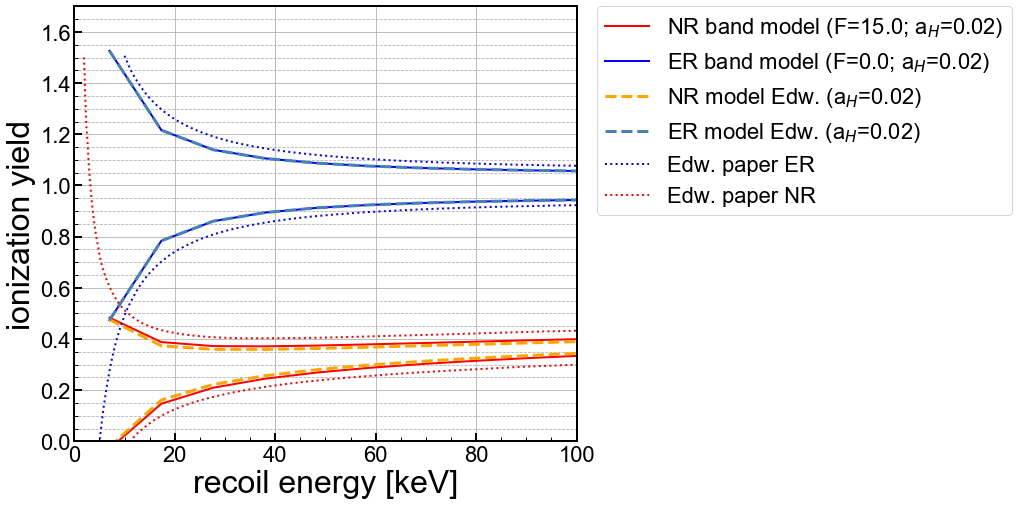

In [14]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


#X = np.arange(0.1,100,0.1)

erQ = Qer(erE)
nrQ = Qbar(nrE)

# plot the data-theifed bands
#ax1.plot(band_data.x[band_data.x>7.82], band_data.Curve1[band_data.x>7.82], 'b-',label='')
#ax1.plot(band_data.x, band_data.curve2, 'b-',label='')
#ax1.plot(band_data.x, band_data.curve3, 'r-',label='')
#ax1.plot(band_data.x, band_data.curve4, 'r-',label='')
ax1.plot(nrE,nrQ+1.645*nrsigma,'r-',linewidth=2,label='NR band model (F={:2.1f}; a$_H$={})'.format(F,aH))
ax1.plot(erE,erQ+1.645*ersigma,'b-',linewidth=2,label='ER band model (F={:2.1f}; a$_H$={})'.format(Fp,aH))
ax1.plot(nrE,nrQ-1.645*nrsigma,'r-',linewidth=2)
ax1.plot(erE,erQ-1.645*ersigma,'b-',linewidth=2)

ax1.plot(nrE,nrQ+1.645*sigQnrv(nrE),color='orange',linestyle='--',linewidth=3,label='NR model Edw. (a$_H$={})'.format(aH))
ax1.plot(erE,erQ+1.645*sigQerv(erE),color='steelblue',linestyle='--',linewidth=3,label='ER model Edw. (a$_H$={})'.format(aH))
ax1.plot(nrE,nrQ-1.645*sigQnrv(nrE),color='orange',linestyle='--',linewidth=3)
ax1.plot(erE,erQ-1.645*sigQerv(erE),color='steelblue',linestyle='--',linewidth=3)

#svg-extracted
# plot the svg? electron-recoil bands
ax1.plot(band_data_svg[12][band_data_svg[13]>1], band_data_svg[13][band_data_svg[13]>1], 'b:', linewidth=2, \
        label='Edw. paper ER')
ax1.plot(band_data_svg[12][band_data_svg[13]<1], band_data_svg[13][band_data_svg[13]<1], 'b:', linewidth=2,label='')

# nuclear recoil bands
ax1.plot(band_data_svg[8], band_data_svg[9], 'r:', linewidth=2, label="Edw. paper NR")
ax1.plot(band_data_svg[10], band_data_svg[11], 'r:', linewidth=2, label='')

#ax1.plot(X,ynr_muv(X),'r--',label='NR mu')
#ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
#ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

#ax1.plot(X,yer_muv(X),color='orange',linestyle='--',label='ER mu')
#ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='orange',linestyle='-',label='ER 3$\sigma$')
#ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='orange',linestyle='-',label=None)



#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)


ymin = 0
ymax = 1.7



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=1,prop={'size':22})
lgd = ax1.legend(bbox_to_anchor=(1.04,1),loc='upper left',borderaxespad=0,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

#plt.tight_layout()
#plt.savefig('figures/GGA1_bandModel.png')
plt.savefig('figures/GGA1_bandModel.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Matching Published and Calculated Widths

It is obvious from the plot above that, while our calculation using the fully correct distribution in the ionization-recoil plane matches very well with the Edw. paper model, it does not match with the bands extracted from Fig. 5 of the Edw. paper. I should plot these more carefully and look for discrepancies. 

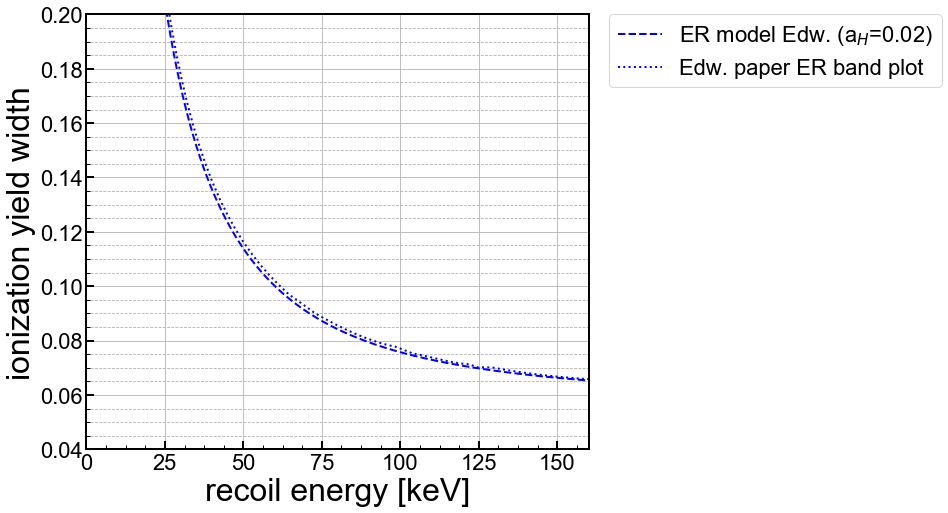

In [15]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes




X=np.arange(0.1,160,0.1)


#ax1.plot(X,sigQnrv(X),color='r',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH))
#ax1.plot(X,1.645*sigQerv(X),color='b',linestyle="--",linewidth=2,label='ER model Edw. (a$_H$={})'.format(aH))
ax1.plot(X,2.2*sigQerv(X),color='b',linestyle="--",linewidth=2,label='ER model Edw. (a$_H$={})'.format(aH))
ax1.plot(band_data_svg[12][band_data_svg[13]>1], band_data_svg[13][band_data_svg[13]>1]-1.0, 'b:', linewidth=2, \
        label='Edw. paper ER band plot')





ymin = 0.04
ymax = 0.2



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 160) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=1,prop={'size':22})
#ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.5),prop={'size':22})
lgd = ax1.legend(bbox_to_anchor=(1.04,1),loc="upper left",borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

#plt.tight_layout()
#plt.savefig('figures/figure.png')
#plt.savefig('figures/figure.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

So, by adjusting $a_H$ to 0.02 **_and_** increasing the ER model do report 2.2$\sigma$ we get close. I can keep playing this game until I get the curve right, but why in the world would Edw. have plotted some arbitrary value like 2.2$\sigma$?